### How many new solutions do you get when you run Metient-256,1024, etc. 1, 2, 3 times, and can we use this as a way to predict the sample size needed for a particular input?

In [1]:
import os
import glob
import gzip
import pickle
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from metient.util.vertex_labeling_util import LabeledTree
import metient.util.eval_util as eutil

from metient.util.globals import *

REPO_DIR = '/lila/data/morrisq/divyak/projects/metient/metient/'
TRACERX_RESULTS_DIR = os.path.join(REPO_DIR,"data/tracerx_nsclc/metient_outputs/")


CUDA GPU: False


In [2]:
import numpy as np
# Get all patients
results_dir = os.path.join(TRACERX_RESULTS_DIR, f"pyclone_clustered_conipher_trees_bs256_r1_03292024", "calibrate")
# Use glob to get the list of matching files
matching_files = glob.glob(f'{results_dir}/*pkl.gz')
patients = [m.split("/")[-1].replace(".pkl.gz", "") for m in matching_files]
print(len(patients))

# For each patient, how many new solutions do you get (solutions that not all 
# 5 runs have) with different batch sizes
data = []
num_runs = 5
for bs in [256,1024, 4096,16384,32768, 65536]:
    for pt in patients:
        run_to_pt_solutions = {i:set() for i in range(1,num_runs+1)}
        for run in range(1,6):
            results_fn = os.path.join(TRACERX_RESULTS_DIR, f"pyclone_clustered_conipher_trees_bs{bs}_r{run}_03292024", 
                                       "calibrate", f"{pt}.pkl.gz")           
            with gzip.open(results_fn, 'rb') as f:
                pkl = pickle.load(f)
#                 Vs = pkl[OUT_LABElING_KEY]
#                 As = pkl[OUT_ADJ_KEY]
                num_sites = len(pkl[OUT_SITES_KEY])
                idx_to_label = pkl[OUT_IDX_LABEL_KEY][0]
                num_clone_tree_nodes = len([val[1] for val in idx_to_label.values() if val[1] == False])
                for i in range(len(pkl[OUT_LABElING_KEY])):
#                     V = torch.tensor(V)
#                     A = torch.tensor(A)
#                     tree = LabeledTree(A, V)
#                     print(str(np.where(A == 1)))
#                     print(str(np.where(V == 1)))
                    edges_inferred, mig_edges_inferred = eutil.metient_parse_clone_tree(pkl, i)
                    seeding_clones_inferred = eutil.identify_seeding_clones(edges_inferred, mig_edges_inferred)
                    migration_graph_edges_inferred = eutil.metient_parse_mig_graph(pkl, i)
                    run_to_pt_solutions[run].add((tuple(seeding_clones_inferred), tuple(mig_edges_inferred), tuple(migration_graph_edges_inferred)))
                    
        intersection_solutions = set.intersection(*list(run_to_pt_solutions.values()))
        for run in run_to_pt_solutions:
            solns = run_to_pt_solutions[run]
            num_new_solns = len(solns - intersection_solutions)
            data.append([bs, pt, num_sites, num_clone_tree_nodes,num_new_solns])
            
sampling_df = pd.DataFrame(data, columns=['Sample size', 'Patient', 'Number of anatomical sites', 'Number of clone tree nodes', 'Number of new solutions found'])
sampling_df

125


,Sample size,Patient,Number of anatomical sites,Number of clone tree nodes,Number of new solutions found
0,256,CRUK0468_primary_SU_T1,3,27,2
1,256,CRUK0468_primary_SU_T1,3,27,1
2,256,CRUK0468_primary_SU_T1,3,27,16
3,256,CRUK0468_primary_SU_T1,3,27,1
4,256,CRUK0468_primary_SU_T1,3,27,2
...,...,...,...,...,...
3745,65536,CRUK0022_primary_SU_T1,2,13,0
3746,65536,CRUK0022_primary_SU_T1,2,13,0
3747,65536,CRUK0022_primary_SU_T1,2,13,0
3748,65536,CRUK0022_primary_SU_T1,2,13,0


In [3]:
def get_search_space(num_sites, num_nodes):
    return float(num_sites**(num_nodes-1))
sampling_df['Search space'] = sampling_df.apply(lambda row: get_search_space(row['Number of anatomical sites'], row['Number of clone tree nodes']), axis=1)                                    

09:00:51 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x600 with 0 Axes>

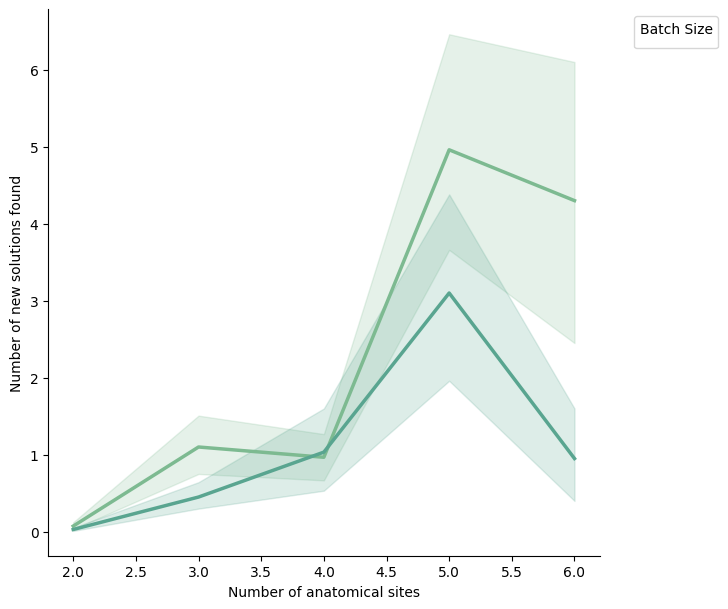

In [11]:
# Create a scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
colors = sns.color_palette("crest")[:2]
# colors = ['red', 'blue']
g = sns.relplot(
    data=sampling_df[sampling_df['Sample size'].isin([256, 65536])], x='Number of anatomical sites', 
    y='Number of new solutions found',
    height=6, dashes=False, linewidth=2.5,palette=colors,
    hue='Sample size', kind="line",style='Sample size', legend=False,
)
    
#plt.xscale("log")
# scatter = sns.scatterplot(data=sampling_df, x='Number of anatomical sites', y='Number of new solutions found', hue='Sample size', palette='deep', style='Sample size')

plt.legend(title='Batch Size', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust the legend
